<a href="https://colab.research.google.com/github/circularmachines/batch_indexing_machine/blob/main/Train%20foundation%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a foundation model on assorted random parts

This is the latest breakthrough in my quest for finding ways to automatically structure and classify random parts, a tech that can be used to build digital circular economy solutions. If we can effectively document unused parts, it's easier to find new uses for them.

Key features:

*   Works with many different types of parts: Legobricks, metal scrap, whatever really...
*   Works in many different types of machines and scenarios, as long as there is some kind of shaking going on, the algorithm should be able to identify individual parts.
*   Facilitates a modern approach to transfer learning. If i had 1000 movies similar to the one below, but with other batches of random parts, I could do a pre-training on the entire dataset and then fine-tune on one batch.

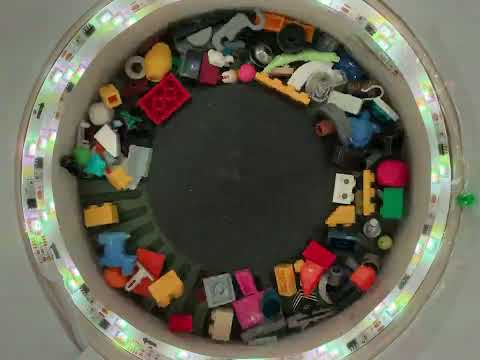

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("NBq8v40ebHE", width=400)

#old movie of a previous revision of the machine, but the priciple is the same

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
login()


In [3]:
import numpy as np
import cv2
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import DefaultDataCollator

In [4]:

data_collator = DefaultDataCollator(return_tensors="tf")

def convert_to_tf_tensor(image: Image):

    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
       # train_data_augmentation(
          convert_to_tf_tensor(image.convert("RGB")) for image in example_batch["image"]  # )
    ]
    #example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images] #If using Transformer network
    example_batch["pixel_values"] = [tf.squeeze(image) for image in images]
    return example_batch



In [5]:
#load green dataset

ds=load_dataset("Circularmachines/batch_indexing_machine_230614", split="train")#, streaming=True)
#ds=load_dataset("/content/drive/MyDrive/green_dataset", split="train")#, streaming=True)
ds.set_transform(preprocess_train)
batch_size=4

tf_ds=ds.to_tf_dataset(columns=["pixel_values"], label_cols="label",  shuffle=False, batch_size=batch_size, collate_fn=data_collator)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


(4, 1088, 1088, 3)


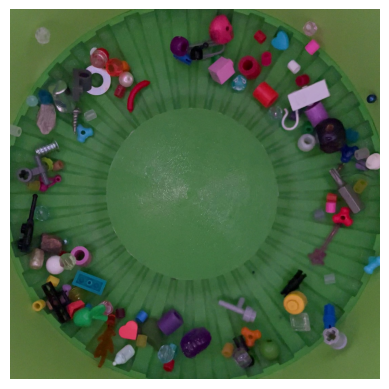

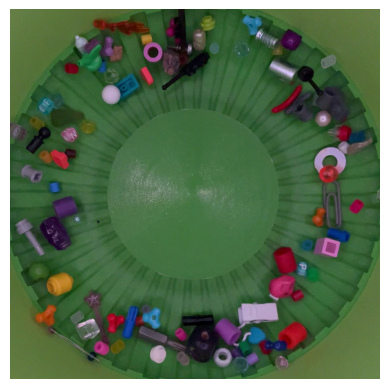

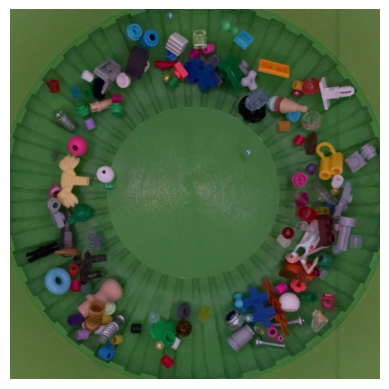

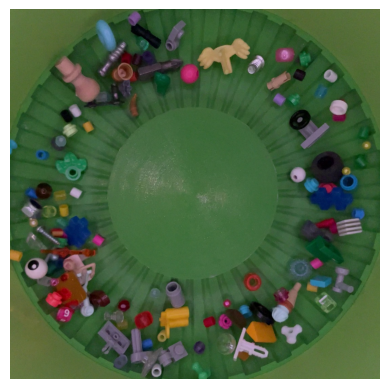

In [ ]:
for d in tf_ds.take(1):
  show=d[0]
  print(d[0].shape)

for s in show:
  plt.imshow(s)
  plt.axis('off')
  plt.show()


# The dataset is paired and then shuffled over all batchs. Images in a pair are separated by 8 time frames, which shifts the parts approximately one quarter of a turn clockwise

In [6]:
# Generate the donut shape


image_size=1088
patch_size=68


def donut(patch_size, img_size, lower_limit=0.5, upper_limit=1):

  gridsize=img_size//2//patch_size

  #create a grid of patch coordinates relative to center of image, and calculate distance from center
  coords=np.array([[(i+0.5,j+0.5) for i in range(-gridsize,gridsize)] for j in range(-gridsize,gridsize)])
  norm=np.linalg.norm(coords,axis=2)

  #we are only interested in the "donut" where the parts are, anything close to the center and far from the center is disregarded
  keep_bool=((norm>(gridsize*lower_limit))*(norm<(gridsize*upper_limit)))
  keep=tf.constant(np.where(keep_bool.flatten())[0],dtype=tf.int32)

  return coords,keep,keep_bool

coords,keep,keep_bool=donut(patch_size,image_size)
n_patches=len(keep)
coords_valid=coords.reshape(-1,2)[keep,:]   #the coordinates in the donut relative to center
angle_sort=(-np.arctan2(coords_valid[:,0],coords_valid[:,1])).argsort() #patch indexes reordered by their angle relative to center
angle_sort_inv=np.zeros(len(keep),dtype=int)
angle_sort_inv[angle_sort]=np.arange(len(keep))
print(keep_bool.astype(int))

# Not interested in patches in the middle or in the corners, because we know that there are no parts there

[[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]]


In [7]:
#final dataset generation with the patches

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        dim_size = tf.shape(images)[-1]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        #patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1,self.patch_size,self.patch_size, dim_size])

        return patches


def grey(x):
  x=tf.reduce_mean(x,axis=-1,keepdims=True)
  x=tf.cast(x,dtype=tf.uint8)
  x=tf.repeat(x,3,axis=-1)
  return x

def random_colors(x,y):
  intensity=0.2
  rand=(tf.random.normal(shape=[3])*intensity)+1
  x=tf.cast(x,rand.dtype)*rand
  x=tf.clip_by_value(x,0,255)
  x=tf.cast(x,dtype=tf.uint8)
  #x=tf.repeat(x,3,axis=-1)
  return x,y

def patch(x,y):
  patches=Patches(patch_size)(x)
  x=tf.gather(patches,indices=keep)
  x=tf.gather(x,indices=angle_sort)
  if grey_images:
    x=grey(x)
#  if random_images:
#    x=random_colors(x)
  return x, tf.repeat(y,keep.shape[0])



grey_images=False
random_images=True

batch_size=4


ds_train=tf_ds.unbatch().batch(1).map(patch).unbatch().map(random_colors).batch(n_patches*2*batch_size,drop_remainder=True)

for d in ds_train.take(1):
  print(d[0].shape)
  batch=d[0]



(1248, 68, 68, 3)


In [8]:
def create_angle_mask(n,fr,to):

  out=np.zeros((n,n),dtype=int)

  for i in range(n):
    out[i,[x%n for x in range(i+fr,i+to)]]=1

  out=np.concatenate([out-1,2*out-1],axis=1)

  out2=np.zeros((n,n),dtype=int)

  for i in range(n):
    out2[i,[x%n for x in range(i-to+1,i-fr+1)]]=1

  out2=np.concatenate([2*out2-1,out2-1],axis=1)

  return np.concatenate([out,out2])

mask=create_angle_mask(n_patches,28,60)[np.newaxis,:,:]

mask=tf.constant(mask,dtype=tf.float32)

mask.shape

TensorShape([1, 312, 312])

If this is the target...


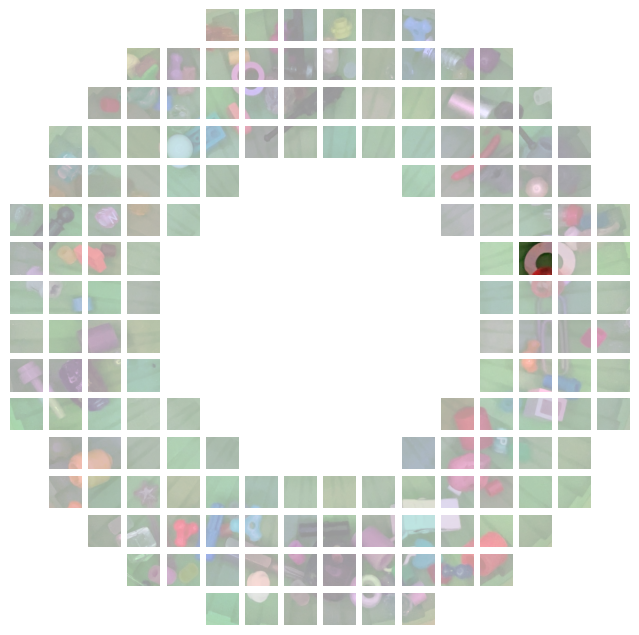

...it's obviously not visible in these patches... (negative example is collected from here)


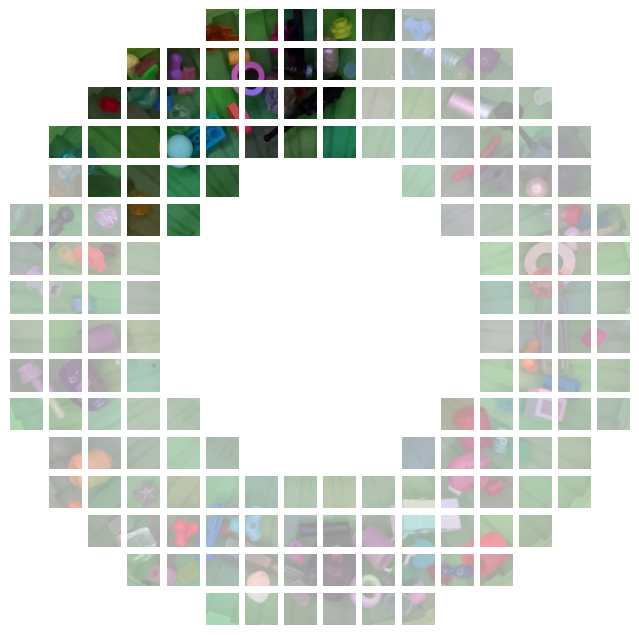

...but it's visible in these patches in another frame of the video. (positive example is collected from here)


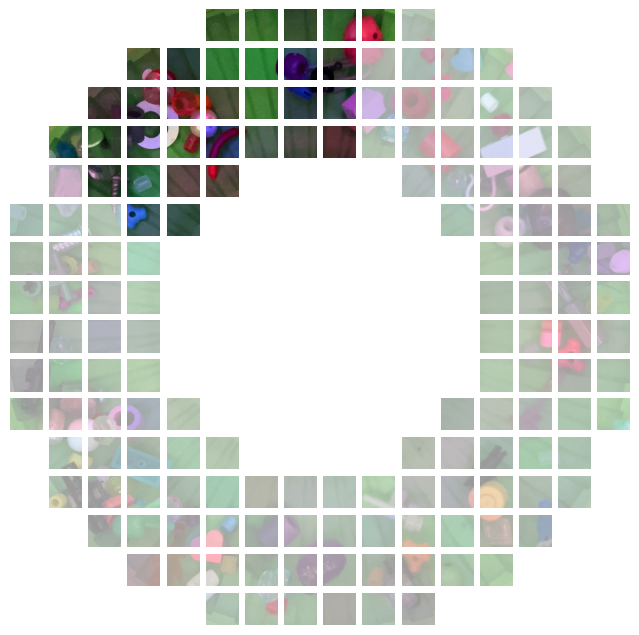

In [9]:
def show_donut(p,v):
  g=image_size//patch_size
  fig = plt.figure(figsize=(8, 8))
  columns = g
  rows = g

  j=0
  for i in range(g*g):
    if i in keep:
      if v[angle_sort_inv[j]]:
        img=p[angle_sort_inv[j]]
      else:
        img=255-((255-np.array(p[angle_sort_inv[j]]))*0.4).astype(int)
      j+=1
    else:
      img=np.ones((patch_size,patch_size,3))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')



  plt.show()



r=n_patches+32

mask_s=np.squeeze(mask)
batch=batch[:len(mask_s)]


print('If this is the target...')
show_donut(batch[n_patches:],tf.one_hot(r-n_patches,n_patches))
print("...it's obviously not visible in these patches... (negative example is collected from here)")
show_donut(batch[n_patches:],mask_s[r]==1)
print("...but it's visible in these patches in another frame of the video. (positive example is collected from here)")
show_donut(batch[:n_patches],mask_s[r]==1)

#Explanation of the algorithm

What the algorithm does, is to compare the feature vector for the target patch to patches highlighted above. The most similar feature vector in each highlighted area above is our negative and positive example.

The training process aims to bring the target closer to the positive example and further from the negative example.

In [10]:


# the custom loss algorithm!

def custom_triple_loss(y_true,y_pred):

  y_pred=tf.cast(y_pred,mask.dtype)

  a=tf.expand_dims(y_pred,axis=1)
  b=tf.expand_dims(y_pred,axis=2)

  distance=tf.reduce_sum(tf.square(a-b),axis=-1)
  distance=tf.sqrt(distance) #contrastive

  maskvalid=tf.cast(tf.equal(mask,-1),mask.dtype)

  distance=distance+maskvalid*1000

  mask0=tf.cast(tf.equal(mask,0),mask.dtype)
  min0=tf.reduce_min(distance + (1-mask0)*1000,axis=2)
  mask1=tf.cast(tf.equal(mask,1),mask.dtype)
  min1=tf.reduce_min(distance + (1-mask1)*1000,axis=2)

  valid_min0=tf.cast(tf.not_equal(min0,0),min0.dtype)  #these are needed when using a chroma keyed images, where everything green is replaced with one sprcific green.
  valid_min1=tf.cast(tf.not_equal(min1,0),min1.dtype)  #Then some patches give exactly the same output which causes some weird behaviour.

  margin=0.5
  return  tf.reduce_mean(valid_min1*tf.math.square(min1) + valid_min0*tf.math.square(tf.math.maximum(margin - min0, 0.0))) #contrastive
  #return tf.reduce_mean(tf.maximum(0.0, min1 - min0 + margin)) #triple





custom_triple_loss(0,np.random.random((4,2*n_patches,64)))
#custom_triple_loss(0,np.ones((4,2*n_patches,64)))



<tf.Tensor: shape=(), dtype=float32, numpy=7.776213>

In [11]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")

cnn=tf.keras.applications.EfficientNetV2S(weights=None, include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp) #Training from scratch seems to be better, but that is not verified

#dropout=tf.keras.layers.Dropout(0.1)(cnn)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,reshape)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 68, 68, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 lambda (Lambda)             (None, 64)                0         
                                                                 
 lambda_1 (Lambda)           (None, 312, 64)           0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
___________________________________________

In [12]:
model.compile(loss=custom_triple_loss, optimizer="adam")


# Training

I use a A100 GPU to train the model for 8 epochs in ~3 hours

In [15]:

# picking up training from a model trained for a few epochs, so setting the learning rate accordingly
model.optimizer.learning_rate=0.0004

In [16]:
from huggingface_hub import HfApi
api = HfApi()

from datetime import datetime

for epoch in range(8):

  model.fit(ds_train,epochs=1)
  model.optimizer.learning_rate=model.optimizer.learning_rate.numpy()*0.8
  print(model.optimizer.learning_rate)
  model.save_weights('weights.h5')



  # Get the current date and time
  current_datetime = datetime.now()

  # Format the date and time according to the European standard
  european_datetime = current_datetime.strftime('%Y-%m-%d-%H-%M-%S')

  model_name='green_scratch_randcolors'


  api.upload_file(
      path_or_fileobj='/content/weights.h5',
      path_in_repo="weights_"+model_name+"_"+european_datetime+".h5",
      repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss",
      repo_type="model",
  )

1890/1890 [==============================] - 1379s 674ms/step - loss: 0.1029
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00032>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1281s 678ms/step - loss: 0.1006
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.000256>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1282s 678ms/step - loss: 0.0983
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002048>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1278s 676ms/step - loss: 0.0960
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00016384>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1277s 676ms/step - loss: 0.0938
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.000131072>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1281s 678ms/step - loss: 0.0920
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.000104857594>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1281s 678ms/step - loss: 0.0906
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.388607e-05>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

1890/1890 [==============================] - 1278s 676ms/step - loss: 0.0895
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.710886e-05>


weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

#Create Testset database


In [17]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")#, batch_size=n_patches*8)

cnn=tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

#reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,l2norm)

model.summary()

82420632/82420632 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 68, 68, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 lambda_2 (Lambda)           (None, 64)                0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
_________________________________________________________________


In [18]:
model.load_weights('weights.h5')

In [19]:
from datasets import load_dataset

ds_test=load_dataset("Circularmachines/batch_indexing_machine_green_test",split="test")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/420 [00:00<?, ? examples/s]

In [20]:


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        dim_size = tf.shape(images)[-1]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size//2, self.patch_size//2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        #patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1,self.patch_size,self.patch_size, dim_size])

        return patches

In [21]:
#when creating the test set predictions, i do inference on all patches, even if they are outside of the donut and don't contain any parts.

def grey(x):
  x=tf.reduce_mean(x,axis=-1,keepdims=True)
  x=tf.cast(x,dtype=tf.uint8)
  x=tf.repeat(x,3,axis=-1)
  return x

grey_images=False

def basic_patch(x):

  x=Patches(patch_size)(x)
  if grey_images:
    x=grey(x)
  return x


In [22]:
ds=tf.data.Dataset.from_tensor_slices(np.array([np.array(d['image']) for d in ds_test])).batch(1).map(basic_patch)
pred=model.predict(ds)
pred.shape

420/420 [==============================] - 30s 61ms/step


(403620, 64)

In [23]:
import pandas as pd

pred_df=pd.DataFrame(np.array(pred).reshape(-1,64))
pred_df.to_csv('test.csv')

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj='test.csv',
    path_in_repo="test_green_230809.csv",
    repo_id="Circularmachines/Batch_indexing_machine_pred_csv",
    repo_type="dataset",
)

test.csv:   0%|          | 0.00/305M [00:00<?, ?B/s]

In [ ]:
from google.colab import runtime
runtime.unassign()

In [13]:

from huggingface_hub import hf_hub_download
# Download from a dataset
file_name=hf_hub_download(repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss", filename="weights_green_scratch_randcolors_2023-08-08-14-04-47.h5")#, repo_type="dataset")
file_name

'/root/.cache/huggingface/hub/models--Circularmachines--batch_indexing_machine_64x64_triple_loss/snapshots/b9f95f5d3886522fc2691ab93eb9de8167b5188c/weights_green_scratch_randcolors_2023-08-08-14-04-47.h5'

In [14]:
model.load_weights(file_name)